<a href="https://colab.research.google.com/github/oferbaharav/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Copy_of_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [18]:
#  Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' 
#and the sale price was more than 100 thousand and less than 2 million.
df.head(2)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019


In [0]:
# the most extreme .1% longitudes
import numpy as np
df = df[(df['SALE_PRICE'] >= np.percentile(df['SALE_PRICE'], 0.5)) & 
        (df['SALE_PRICE'] <= np.percentile(df['SALE_PRICE'], 99.5))]
       

In [20]:
df_subset = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]
df_subset.head(2)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019


In [21]:
df_subset.SALE_DATE.max()

'04/30/2019'

In [22]:
df_subset.SALE_DATE.min()

'01/01/2019'

In [0]:
#  Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2507, 21) (644, 21)


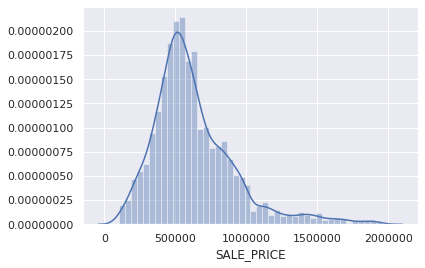

In [23]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

df_subset['SALE_DATE'] = pd.to_datetime(df_subset['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('04/01/2019')
train = df_subset[df_subset.SALE_DATE < cutoff]
test = df_subset[df_subset.SALE_DATE >= cutoff]
print(train.shape, test.shape)
AX = sns.distplot(df_subset['SALE_PRICE'])





In [24]:
# to find cardinality of categorical variables
train.select_dtypes(exclude='number').describe().T 

,count,unique,top,freq,first,last
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,7,OTHER,2360,NaT,NaT
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
ADDRESS,2507,2497,216-29 114TH ROAD,2,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
LAND_SQUARE_FEET,2507,887,"4,000",234,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


In [0]:
target = 'SALE_PRICE'
#SALE_DATE not categorical, but need to mask it due to datetime which is a 
#datatype the mnodel below in kfeatures selections cannot read
high_cardinality = ['ADDRESS', 'APARTMENT_NUMBER', 'LAND_SQUARE_FEET', 'SALE_DATE', 'EASE-MENT', 'BOROUGH',
'NEIGHBORHOOD', 'BUILDING_CLASS_AT_PRESENT'] 
features = train.columns.drop([target] + high_cardinality)
#X is input y is output
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]



In [26]:
!pip install category_encoders

In [27]:
#do one hot encoding of categorical features
import category_encoders as ce 
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [28]:
#feature selection, picking the top 15
from sklearn.feature_selection import f_regression, SelectKBest
selector = SelectKBest(score_func = f_regression, k=15)
x_train_selected = selector.fit_transform(X_train, y_train)
x_test_selected = selector.transform(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [29]:
#check what x_train_selected returns
x_train_selected

array([[1.0000e+00, 0.0000e+00, 5.4950e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 7.9180e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 4.2100e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 0.0000e+00, 1.1320e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 3.3950e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 1.1159e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [30]:
# kfeatures still didn't work. Checking for NaN in error and finding that it's in EASE-MENT
X_train.isna().sum()

BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS    0
TAX_CLASS_AT_PRESENT_1                             0
TAX_CLASS_AT_PRESENT_1D                            0
BLOCK                                              0
LOT                                                0
ZIP_CODE                                           0
RESIDENTIAL_UNITS                                  0
COMMERCIAL_UNITS                                   0
TOTAL_UNITS                                        0
GROSS_SQUARE_FEET                                  0
YEAR_BUILT                                         0
TAX_CLASS_AT_TIME_OF_SALE                          0
BUILDING_CLASS_AT_TIME_OF_SALE_A9                  0
BUILDING_CLASS_AT_TIME_OF_SALE_A1                  0
BUILDING_CLASS_AT_TIME_OF_SALE_A5                  0
BUILDING_CLASS_AT_TIME_OF_SALE_A0                  0
BUILDING_CLASS_AT_TIME_OF_SALE_A2                  0
BUILDING_CLASS_AT_TIME_OF_SALE_A3                  0
BUILDING_CLASS_AT_TIME_OF_SALE_S1             

In [0]:
# We did a different feature selection above. But this is another one taught
#in class 
#  Do feature selection with SelectKBest.

# def engineer_features(X):
    
#     # Avoid SettingWithCopyWarning
#     X = X.copy()
    
#     # How many total perks does each apartment have?
#     perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
#                  'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
#                  'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
#                  'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
#                  'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
#                  'loft', 'garden_patio', 'common_outdoor_space', 
#                  'wheelchair_access']
#     X['perk_count'] = X[perk_cols].sum(axis=1)

#     # Are cats or dogs allowed?
#     X['cats_or_dogs'] = (X['cats_allowed']==1) | (X['dogs_allowed']==1)

#     # Are cats and dogs allowed?
#     X['cats_and_dogs'] = (X['cats_allowed']==1) & (X['dogs_allowed']==1)

#     # Total number of rooms (beds + baths)
#     X['rooms'] = X['bedrooms'] + X['bathrooms']

#     return X

# X_train = engineer_features(X_train)
# X_test = engineer_features(X_test)



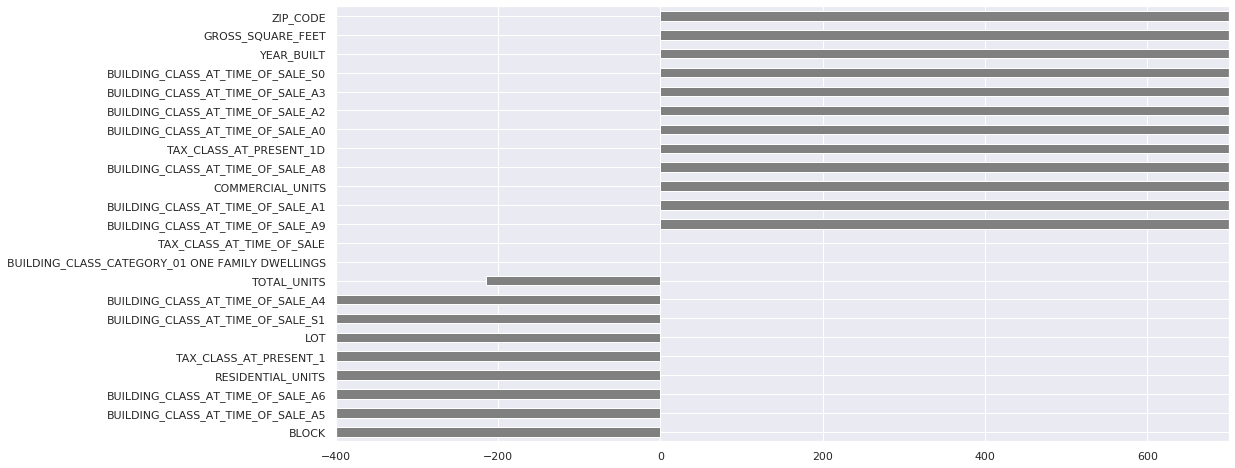

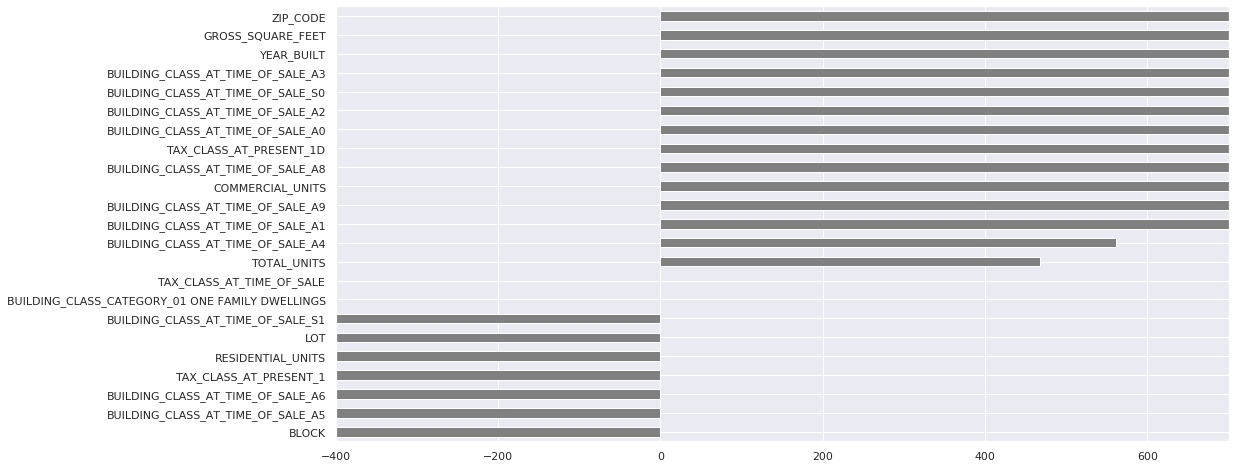

In [31]:
#  Do feature scaling. Use the scaler's fit_transform method with the train set. Use the scaler's transform method with the test set.
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error


# Try a range of alpha parameters for Ridge Regression.

# The scikit-learn docs explain, 
# alpha : Regularization strength; must be a positive float. Regularization 
# improves the conditioning of the problem and reduces the variance of the 
# estimates. Larger values specify stronger regularization.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

for alpha in [10**1,10**2]: 
              #10**3, 10**4, 10**5, 10**6]:
    
    # Scale data before doing Ridge Regression
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
      
      # Fit Ridge Regression model
  display(HTML(f'Ridge Regression, with alpha={alpha}'))
  model = Ridge(alpha=alpha)
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)

      # Get Test MAE
  mae = mean_absolute_error(y_test, y_pred)
  display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
      
      # Plot coefficients
  coefficients = pd.Series(model.coef_, X_train.columns)
  plt.figure(figsize=(16,8))
  coefficients.sort_values().plot.barh(color='grey')
  plt.xlim(-400,700)
  plt.show()

In [32]:
#seeing how I did in the prediction vs actual in terms of error (Mean Absolute Error)
#R^2
from sklearn.metrics import mean_squared_error

     # Get Test MSE
mse = mean_squared_error(y_test, y_pred)
display(HTML(f'Test Mean Square Error: ${mse:,.0f}'))



In [0]:
#  Fit a ridge regression model with multiple features.


In [0]:
#  Get mean absolute error for the test set.


In [0]:
#  As always, commit your notebook to your fork of the GitHub repo.